In [3]:
import pickle
import torch.autograd as autograd
import numpy as np
import pandas as pd
from collections import Counter
%matplotlib inline

In [5]:
catergory = pd.read_csv('with_category.csv')
chartime = np.load('charttime_string.npy')

In [ ]:
voc = np.load('voc_100.npy')

In [363]:
timeline = '12h'

In [364]:
attention_name = 'val_result_'+timeline + '.pickle'
data_name = 'val_'+timeline+'.npy'

In [365]:
attentions = pickle.load(open(attention_name,'rb'))

In [366]:
data = np.load(data_name)

In [367]:
notes_attention = attentions['notes_attention']
words_attention = attentions['words_attention']
notes_max_attention = attentions['notes_max_attention']
words_max_attention = attentions['words_max_attention']

In [368]:
notes_attention = [list(notes_attention[i][0].data.numpy()[0]) for i in range(len(notes_attention))]
notes_max_attention = [Counter(list(notes_max_attention[i].data.numpy()[0].T[0])) for i in range(len(notes_max_attention))]

In [369]:
words_attention = [[list(words_attention[i][j].data.numpy()[0]) for j in range(len(words_attention[i]))] for i in range(len(words_attention))]

In [370]:
notes_max_attention_new = []
for j in range(len(notes_max_attention)):
    notes_max_attention_new.append([value for _, value in notes_max_attention[j].most_common()])

In [371]:
notes_max_attention = notes_max_attention_new

In [333]:
words_max_attention_all = []
for i in range(len(words_max_attention)):
    words_max_attention_total = []
    for j in range(len(words_max_attention[i])):
        words_max_attention_kk = Counter(list(words_max_attention[i][j].data.numpy()[0].T[0]))
        words_max_attention_kk_keys = list(words_max_attention_kk.keys())
        for h in range(max(words_max_attention_kk_keys)):
            if h not in words_max_attention_kk:
                words_max_attention_kk[h] = 0
                
        words_max_attention_kk = [value for _, value in words_max_attention_kk.most_common()]
        words_max_attention_total.append(words_max_attention_kk)
    words_max_attention_all.append(words_max_attention_total)

In [315]:
words_max_attention = words_max_attention_all

In [372]:
def topN(a,N):
    return np.argsort(a)[::-1][:N]

In [373]:
topN_index = [topN(notes_attention[i],1) for i in range(len(notes_attention))]

In [374]:
topN_index_max = [topN(notes_max_attention[i],1) for i in range(len(notes_max_attention))]

In [375]:
top_noteID = [data.item()['NOTE_ID'][i][topN_index[i][0]] for i in range(len(topN_index))]
top_noteID_max = [data.item()['NOTE_ID'][i][topN_index_max[i][0]] for i in range(len(topN_index_max))]

In [376]:
key = [str(data.item()['SUBJECT_ID'][j])+' '+ chartime[top_noteID[j]] for j in range(len(top_noteID))]
key_max = [str(data.item()['SUBJECT_ID'][j])+' '+ chartime[top_noteID_max[j]] for j in range(len(top_noteID_max))]

In [377]:
notes_types = []
for j in range(len(key)):
    try:
        notes_types.append(catergory[catergory.KEY == key[j]].CATEGORY.values[0])
    except IndexError:
        pass       

In [242]:
notes_types_max = []
for j in range(len(key_max)):
    try:
        notes_types_max.append(catergory[catergory.KEY == key_max[j]].CATEGORY.values[0])
    except IndexError:
        pass 

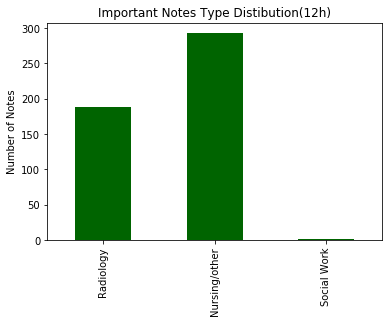

In [378]:
Notes_type_counts = Counter(notes_types)
df = pd.DataFrame.from_dict(Notes_type_counts, orient='index')
ax = df.plot( kind='bar',legend = False, color='darkgreen')
ax.set_ylabel("Number of Notes")
ax.set_title('Important Notes Type Distibution'+ '(' +timeline+')')

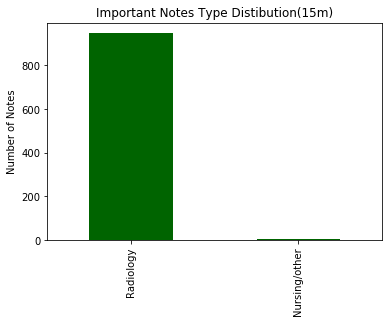

In [244]:
Notes_type_counts_max = Counter(notes_types_max)
df_max = pd.DataFrame.from_dict(Notes_type_counts_max, orient='index')
ax_max = df_max.plot( kind='bar',legend = False, color='darkgreen')
ax_max.set_ylabel("Number of Notes")
ax_max.set_title('Important Notes Type Distibution'+ '(' +timeline+')')

In [69]:
np.unique(catergory['CATEGORY'].values)

array(['Case Management ', 'Consult', 'General', 'Nursing',
       'Nursing/other', 'Nutrition', 'Pharmacy', 'Physician ', 'Radiology',
       'Rehab Services', 'Respiratory ', 'Social Work'], dtype=object)

In [245]:
import matplotlib as mpl
import matplotlib.cm as cm

def print_visualisation(X, Y, notes_types, SUBJECT_ID, notes_attention, time_line, output_file):
    max_total = max([val for sublist in Y for val in sublist])
    min_total = min([val for sublist in Y for val in sublist])
    norm = mpl.colors.Normalize(vmin=min_total, vmax=max_total+0.5*max_total)
    cmap = cm.YlGn
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    output_file=open(output_file, 'w+')
    print('<div align="center">', file=output_file)
    print('<h2 style  = "font-family:courier;">'+ time_line + '  Subject ID '+str(SUBJECT_ID) +'</h2>', file = output_file)
    print('</div>', file = output_file)
    print('<div>', file=output_file)
    for k in range(len(X)):
        print('<h3 style = "font-family:Comic Sans MS;"> Note Type: '+str(notes_types[k]) +' attention weight: ' + str(notes_attention[k])+ '</h3>', file = output_file)
        for i in range(len(X[k])):
            print('<span style="background-color:' + str((mpl.colors.to_hex(m.to_rgba(Y[k][i])).upper()))\
                  +';font-family:verdana;">'+''.join(X[k][i])+'</span>', file = output_file)
        print('</br>', file = output_file) 
        print('</br>', file = output_file)
    print('</div>', file = output_file)

In [379]:
for j in range(len(data.item()['DATA'])):
    if j % 50 == 0:
        print('The %d th patient\n'%j)
    text_note_total = []
    for i in range(len(data.item()['DATA'][j])):
        note = data.item()['DATA'][j][i]
        text_note = [voc[note[j]-1] for j in range(len(note))]
        text_note_total.append(text_note)
    attention = words_attention[j]
    # Weight the word level attention by note level attention
    for k in range(len(attention)):
        attention[k] = list(np.array(attention[k])*notes_attention[j][k])
    output_file = 'SUBJECT_ID_'+str(data.item()['SUBJECT_ID'][j]) +'.html'

    print_visualisation(text_note_total, attention, notes_types,data.item()['SUBJECT_ID'][j],notes_attention[j],timeline, output_file)

The 0 th patient

The 50 th patient

The 100 th patient

The 150 th patient

The 200 th patient

The 250 th patient

The 300 th patient

The 350 th patient

The 400 th patient

The 450 th patient

The 500 th patient



IndexError: list index out of range

In [320]:
for j in range(len(data.item()['DATA'])):
    if j % 50 == 0:
        print('The %d th patient\n'%j)
    text_note_total = []
    for i in range(len(data.item()['DATA'][j])):
        note = data.item()['DATA'][j][i]
        text_note = [voc[note[j]-1] for j in range(len(note))]
        text_note_total.append(text_note)
    attention = words_max_attention[j]
    # Weight the word level attention by note level attention
    for k in range(len(attention)):
        attention[k] = list(np.array(attention[k])*notes_attention[j][k])
    output_file = 'SUBJECT_ID_'+str(data.item()['SUBJECT_ID'][j]) +'.html'
    print(np.shape(attention))
    print_visualisation(text_note_total, attention, notes_types,data.item()['SUBJECT_ID'][j],notes_attention[j],timeline, output_file)

The 0 th patient

(1, 179)


IndexError: list index out of range

In [497]:
notes_attention[0][1]

0.29733074